# Studying the performance difference of different LLMs in elicitation

In [1]:
import os
import tqdm
from pathlib import Path
import json
import textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from llm_elicited_priors.plotting import graph_theme
from llm_elicited_priors.utils import load_nested_dict_to_pandas

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [3]:
RESULTS_PATH = Path(os.path.join("results", "elicitation"))

In [4]:
def load_result_dicts(path: Path):
    results_files = [
        f for f in os.listdir(path) 
        if (f.endswith(".json") and f.startswith("prior_no_prior"))
    ]
    print(f"Loading {len(results_files)} files from {path}")
    results_dicts = [
        json.load(open(os.path.join(path, f), "r"))
        for f in results_files
    ]

    return results_files, results_dicts

In [5]:
def result_dicts_to_df(results_files, results_dicts):
    results_dfs = [
        load_nested_dict_to_pandas(
            results_dict, level_names=["dataset", "run", "n_data_points_seen", "prior_type"]
        ).assign(results_file_name=results_file_name)
        
        for results_dict, results_file_name in zip(results_dicts, results_files)
    ]

    results_df = pd.concat(
        results_dfs
    ).astype(
        {
            "n_data_points_seen": int,
        }
    )

    return results_df

In [6]:
# results directory for each model
model_results_dir_dict = {
    "uninformative": "uninformative",
    "gpt_prior": "gpt-3-5-turbo-0125",
    "llama_8_prior": "meta-llama-llama-3-1-8b-instruct",
    "llama_3_prior": "meta-llama-llama-3-2-3b-instruct",
    "llama_70_bf16_prior":"meta-llama-llama-3-1-70b-instruct-bfloat16",
    "qwen_14_prior": "qwen-qwen2-5-14b-instruct",
    "gpt_4o_mini_prior": "gpt-4o-mini-2024-07-18",
    "gpt_4_turbo_prior": "gpt-4-turbo-2024-04-09",
}

results_df = pd.DataFrame()

for model_name, model_results_dir in tqdm.tqdm(
    model_results_dir_dict.items(), desc="Loading results"
):
    results_df = pd.concat(
        [
            results_df,
            # loading the results from the dictionaries to a dataframe
            result_dicts_to_df(
                # loading the files to dictionaries
                *load_result_dicts(RESULTS_PATH.joinpath(model_results_dir))
            ).replace(
                # adding the model name
                {"prior_type": {"informative": model_name}}
            )
        ]
    )

Loading results:   0%|          | 0/8 [00:00<?, ?it/s]

Loading 80 files from results/elicitation/uninformative


Loading results:  12%|█▎        | 1/8 [00:02<00:19,  2.82s/it]

Loading 80 files from results/elicitation/gpt-3-5-turbo-0125


Loading results:  25%|██▌       | 2/8 [00:05<00:17,  2.87s/it]

Loading 80 files from results/elicitation/meta-llama-llama-3-1-8b-instruct


Loading results:  38%|███▊      | 3/8 [00:09<00:15,  3.18s/it]

Loading 80 files from results/elicitation/meta-llama-llama-3-2-3b-instruct


Loading results:  50%|█████     | 4/8 [00:12<00:13,  3.32s/it]

Loading 80 files from results/elicitation/meta-llama-llama-3-1-70b-instruct-bfloat16


Loading results:  62%|██████▎   | 5/8 [00:16<00:10,  3.36s/it]

Loading 80 files from results/elicitation/qwen-qwen2-5-14b-instruct


Loading results:  75%|███████▌  | 6/8 [00:19<00:06,  3.42s/it]

Loading 80 files from results/elicitation/gpt-4o-mini-2024-07-18


Loading results:  88%|████████▊ | 7/8 [00:23<00:03,  3.53s/it]

Loading 80 files from results/elicitation/gpt-4-turbo-2024-04-09


Loading results: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it]


In [7]:
dataset_metric_to_plot = {
    "fake_data": "mse",
    "uti": "accuracy",
    "breast_cancer": "accuracy",
    "california_housing": "mse",
    "heart_disease": "accuracy",
    "wine_quality": "accuracy",
    "diabetes": "mse",
    "hypothyroid": "accuracy",
}
dataset_rename = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "heart_disease": "Heart Disease",
    "wine_quality": "Wine Quality", 
    "diabetes": "Diabetes",
    "hypothyroid": "Hypothyroid",
}


accuracy_results = (
    results_df
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .set_index(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .assign(metrics_to_plot=lambda df: df["metrics_to_plot"].apply(np.mean))
    .reset_index()
    .replace({"dataset": dataset_rename})
    .loc[lambda df: df["n_data_points_seen"].isin([5, 10, 20, 25, 30, 40])]
)
accuracy_results

,dataset,n_data_points_seen,prior_type,run,metrics_to_plot
1,UTI,5,uninformative,9,0.547412
2,UTI,10,uninformative,9,0.593408
3,UTI,20,uninformative,9,0.680427
4,UTI,30,uninformative,9,0.627394
5,UTI,40,uninformative,9,0.647622
...,...,...,...,...,...
4474,California Housing,5,gpt_4_turbo_prior,1,19.787508
4475,California Housing,10,gpt_4_turbo_prior,1,13.367349
4476,California Housing,20,gpt_4_turbo_prior,1,16.847807
4477,California Housing,30,gpt_4_turbo_prior,1,5.387637


In [8]:
accuracy_results_line_plot = accuracy_results

In [9]:
method_names = {
    "uninformative": "Uninformative prior", 
    "gpt_prior": "GPT-3.5 turbo prior", 
    "llama_3_prior": "Llama 3.2 3B prior", 
    "llama_8_prior": "Llama 3.1 8B prior", 
    "llama_70_bf16_prior": "Llama 3.1 70B BF16 prior", 
    "qwen_14_prior": "Qwen 2.5 14B prior", 
    "gpt_4o_mini_prior": "GPT-4o mini prior", 
    "gpt_4_turbo_prior": "GPT-4 turbo prior", 
}

palette = {
    method_names["uninformative"]: "xkcd:bright orange",
    method_names["gpt_prior"]: "xkcd:bright blue",
    method_names["llama_3_prior"]: "xkcd:pinkish purple",
    method_names["llama_8_prior"]:  "xkcd:purple",
    method_names["llama_70_bf16_prior"]: "xkcd:deep purple",
    method_names["qwen_14_prior"]: "xkcd:bright red",
    method_names["gpt_4o_mini_prior"]: "xkcd:pinkish purple",
    method_names["gpt_4_turbo_prior"]: "xkcd:purple",
}

markers = {
    method_names["uninformative"]: "o",
    method_names["gpt_prior"]: "X",
    method_names["llama_8_prior"]: "s",
    method_names["llama_3_prior"]: "*",
    method_names["llama_70_bf16_prior"]: "P",
    method_names["qwen_14_prior"]: "d",
    method_names["gpt_4o_mini_prior"]: "d",
    method_names["gpt_4_turbo_prior"]: "P",
}

dashes = {
    method_names["uninformative"]: (1, 0),
    method_names["gpt_prior"]: (1, 0), 
    method_names["llama_3_prior"]: (2,1,1,1),
    method_names["llama_8_prior"]: (6,1,1,1),
    method_names["llama_70_bf16_prior"]: (10,1,1,1),
    method_names["qwen_14_prior"]: (2,1,),
    method_names["gpt_4o_mini_prior"]: (4,1,1,1),
    method_names["gpt_4_turbo_prior"]: (2,1,1,1),
}


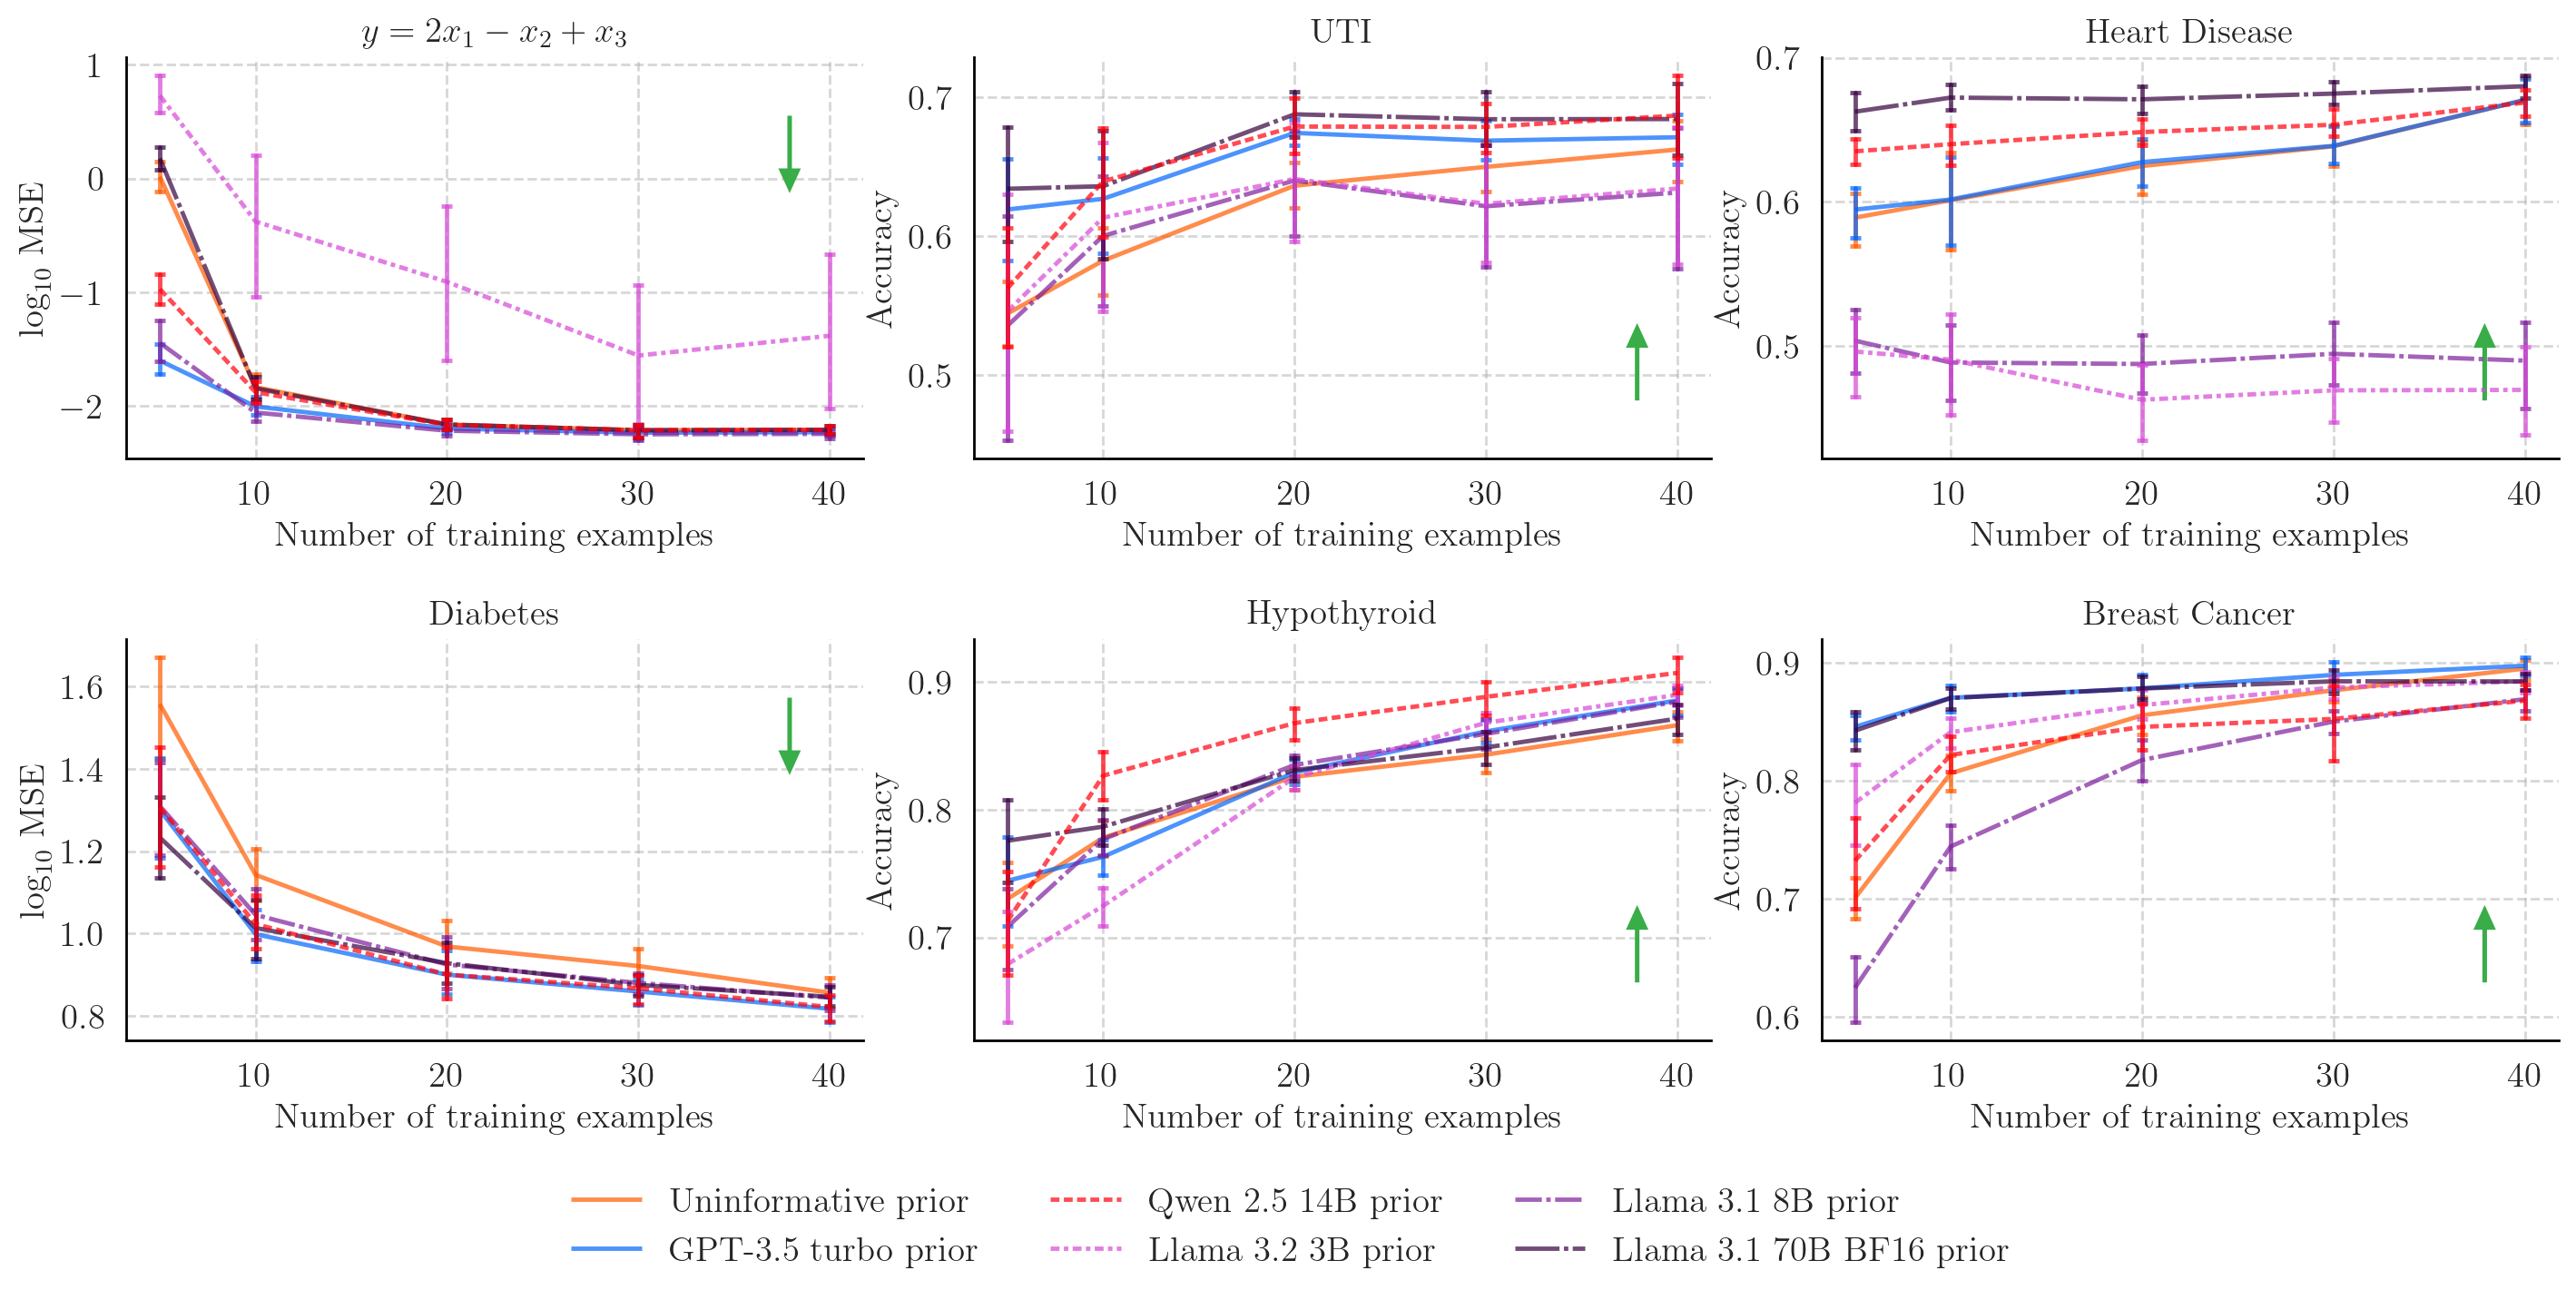

In [12]:
methods_to_plot = [
    "uninformative",
    "gpt_prior",
    "qwen_14_prior",
    "llama_3_prior",
    "llama_8_prior",
    "llama_70_bf16_prior",
]

linewidth_on_plot = 1.75
alpha = 0.7

fontsize=14

datasets_to_plot = [
    r"$y = 2 x_1 - x_2 + x_3$",
    "UTI",
    "Heart Disease",
    "Diabetes",
    "Hypothyroid",    
    "Breast Cancer",
    # "California Housing",
    # "Wine Quality",
]

with graph_theme():
    plt.close()

    fig, axes = plt.subplots(
        2, len(datasets_to_plot)//2, 
        figsize=(2*linewidth, linewidth/1)
    )

    axes = axes.flatten()

    for nax, (dataset, ax) in enumerate(
        zip(
            datasets_to_plot,
            axes
        )
    ):
        
        if dataset in ["Diabetes"]:
            df_to_plot = accuracy_results_line_plot.query(
                "prior_type != 'llama_3_prior'"
            )

        else:
            df_to_plot = accuracy_results_line_plot

        ax = sns.lineplot(
            data=(
                df_to_plot
                .loc[lambda df: df["prior_type"].isin(methods_to_plot)]
                .query("dataset == @dataset")
                .replace({"prior_type": method_names})
                .assign(
                    metrics_to_plot=lambda x: 
                    np.log10(x["metrics_to_plot"].astype(float)) 
                    if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]
                    else x["metrics_to_plot"]
                )
            ),
            x="n_data_points_seen",
            y="metrics_to_plot",
            hue="prior_type",
            palette=palette,
            style="prior_type",
            style_order=[
                method_names[m_name]
                for m_name in methods_to_plot
            ],
            alpha=alpha,
            dashes=dashes,
            err_style="bars",
            errorbar=("ci", 95),
            err_kws=dict(
                capsize=2,
                capthick=linewidth_on_plot,
                elinewidth=linewidth_on_plot,
                linewidth=linewidth_on_plot,
            ),
            markersize=6,
            linewidth=linewidth_on_plot,
            ax=ax,
            legend=False
        )

        if nax == 0:
            if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
            else:
                ax.set_ylabel("Accuracy", fontsize=fontsize)
        else:
            if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
            else:
                ax.set_ylabel("Accuracy", fontsize=fontsize)

        ax.set_xlabel("Number of training examples", fontsize=fontsize)
        ax.tick_params(axis="both", labelsize=fontsize)
        ax.set_title(dataset, fontsize=fontsize)
        ax.set_xticks(np.arange(0, 51, 10))

        y = (
            0.15 
            if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
            else 0.85
        )
        dy = (
            0.075*(0.8/0.3)*(1.4/1.6)*0.75
            if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
            else -0.075*(0.8/0.3)*(1.4/1.6)*0.75
        )
        ax.arrow(
            x=0.9, y=y, 
            dx=0.0, dy=dy,
            head_width=0.05/(1.25*1.33)*0.75, 
            head_length=0.025*(1.25*1.33)*(0.5/0.3)*(1.4/1.6)*0.75,
            color='xkcd:medium green',
            alpha=1.0,
            linewidth=1.5,
            transform=ax.transAxes
        )

    leg = fig.legend(
        loc="lower center",
        labels=[
            method_names[m_name] for m_name in methods_to_plot
        ], 
        handles=[
            plt.Line2D(
                [0,1], [0,1], 
                color=palette[method_names[m_name]], 
                markerfacecolor=palette[method_names[m_name]], 
                markeredgecolor="white",
                markersize=6,
                linewidth=linewidth_on_plot,
                linestyle=(0, dashes[method_names[m_name]]),
                alpha=alpha,
            )
            for m_name in methods_to_plot
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.00),
        ncols=3,
        frameon=False,
    )

    fig.subplots_adjust(
        wspace=0.15,
        hspace=0.45,
        left=0.05,
        right=0.99,
        top=0.96,
        bottom=0.2,
    )

    fig.savefig("results/elicitation_results_lineplot_other_llms.pdf")
    fig.savefig("results/elicitation_results_lineplot_other_llms.svg")
    fig.savefig("results/elicitation_results_lineplot_other_llms.png", dpi=300)

    plt.show()

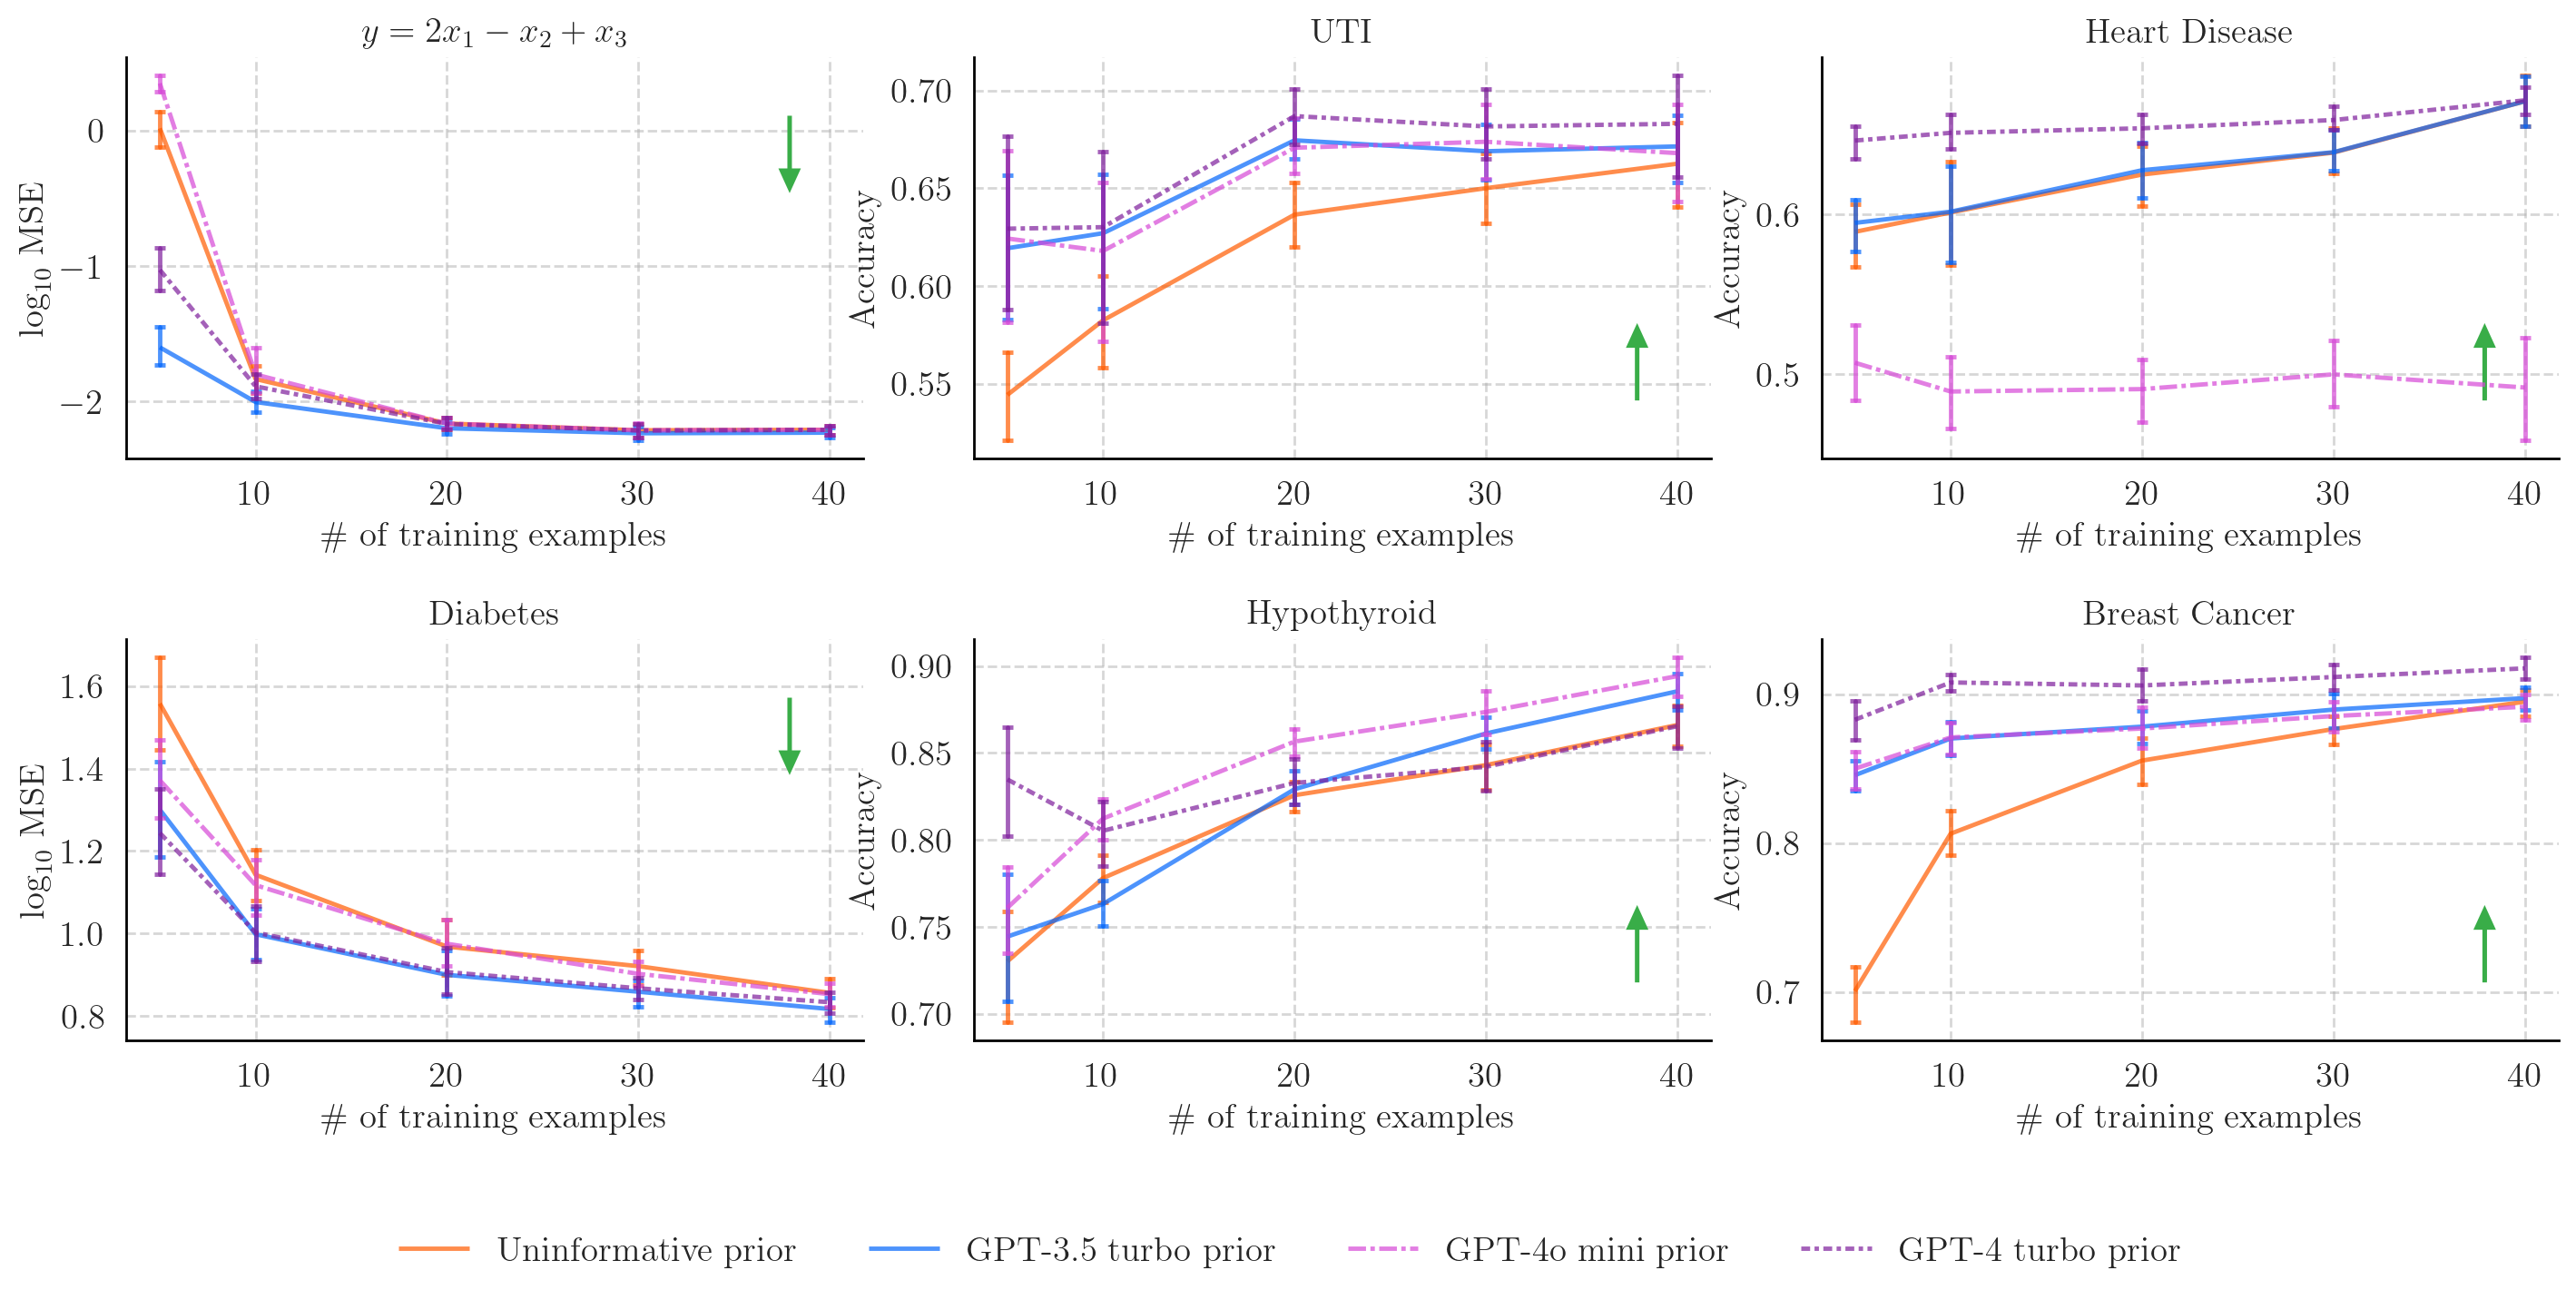

In [13]:
methods_to_plot = [
    "uninformative",
    "gpt_prior",
    "gpt_4o_mini_prior",
    "gpt_4_turbo_prior",
]

linewidth_on_plot = 1.75
alpha = 0.7

fontsize=14

datasets_to_plot = [
    r"$y = 2 x_1 - x_2 + x_3$",
    "UTI",
    "Heart Disease",
    "Diabetes",
    "Hypothyroid",    
    "Breast Cancer",
    # "California Housing",
    # "Wine Quality",
]

with graph_theme():
    plt.close()

    fig, axes = plt.subplots(
        2, len(datasets_to_plot)//2, 
        figsize=(2*linewidth, linewidth/1)
    )

    axes = axes.flatten()

    for nax, (dataset, ax) in enumerate(
        zip(
            datasets_to_plot,
            axes
        )
    ):

        ax = sns.lineplot(
            data=(
                accuracy_results_line_plot
                .loc[lambda df: df["prior_type"].isin(methods_to_plot)]
                .query("dataset == @dataset")
                .replace({"prior_type": method_names})
                .assign(
                    metrics_to_plot=lambda x: 
                    np.log10(x["metrics_to_plot"].astype(float)) 
                    if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]
                    else x["metrics_to_plot"]
                )
            ),
            x="n_data_points_seen",
            y="metrics_to_plot",
            hue="prior_type",
            palette=palette,
            style="prior_type",
            style_order=[
                method_names[m_name]
                for m_name in methods_to_plot
            ],
            alpha=alpha,
            dashes=dashes,
            err_style="bars",
            errorbar=("ci", 95),
            err_kws=dict(
                capsize=2,
                capthick=linewidth_on_plot,
                elinewidth=linewidth_on_plot,
                linewidth=linewidth_on_plot,
            ),
            markersize=6,
            linewidth=linewidth_on_plot,
            ax=ax,
            legend=False
        )

        if nax == 0:
            if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
            else:
                ax.set_ylabel("Accuracy", fontsize=fontsize)
        else:
            if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
            else:
                ax.set_ylabel("Accuracy", fontsize=fontsize)
        ax.set_xlabel("\# of training examples", fontsize=fontsize)
        ax.tick_params(axis="both", labelsize=fontsize)
        ax.set_title(dataset, fontsize=fontsize)
        ax.set_xticks(np.arange(0, 51, 10))

        y = (
            0.15 
            if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
            else 0.85
        )
        dy = (
            0.075*(0.8/0.3)*(1.4/1.6)*0.75
            if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
            else -0.075*(0.8/0.3)*(1.4/1.6)*0.75
        )
        ax.arrow(
            x=0.9, y=y, 
            dx=0.0, dy=dy,
            head_width=0.05/(1.25*1.33)*0.75, 
            head_length=0.025*(1.25*1.33)*(0.5/0.3)*(1.4/1.6)*0.75,
            color='xkcd:medium green',
            alpha=1.0,
            linewidth=1.5,
            transform=ax.transAxes
        )

    leg = fig.legend(
        loc="lower center",
        labels=[
            method_names[m_name] for m_name in methods_to_plot
        ], 
        handles=[
            plt.Line2D(
                [0,1], [0,1], 
                color=palette[method_names[m_name]], 
                markerfacecolor=palette[method_names[m_name]], 
                markeredgecolor="white",
                markersize=6,
                linewidth=linewidth_on_plot,
                linestyle=(0, dashes[method_names[m_name]]),
                alpha=alpha,
            )
            for m_name in methods_to_plot
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.00),
        ncols=5,
        frameon=False,
    )

    fig.subplots_adjust(
        wspace=0.15,
        hspace=0.45,
        left=0.05,
        right=0.99,
        top=0.96,
        bottom=0.2,
    )


    fig.savefig("results/elicitation_results_lineplot_gpts.pdf")
    fig.savefig("results/elicitation_results_lineplot_gpts.svg")
    fig.savefig("results/elicitation_results_lineplot_gpts.png", dpi=300)

    plt.show()